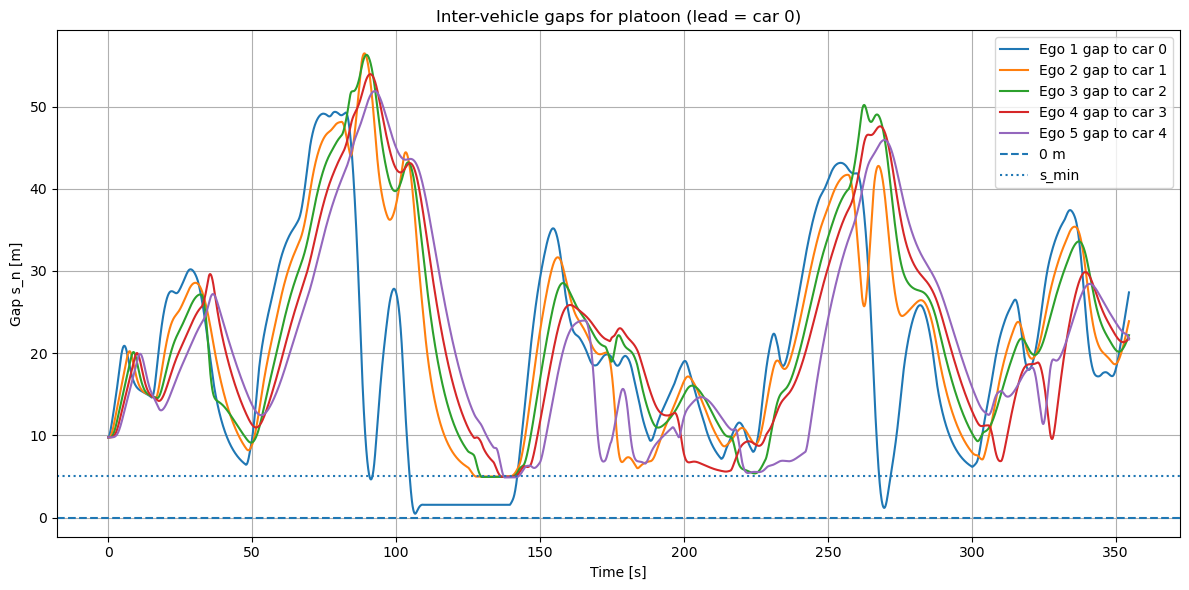

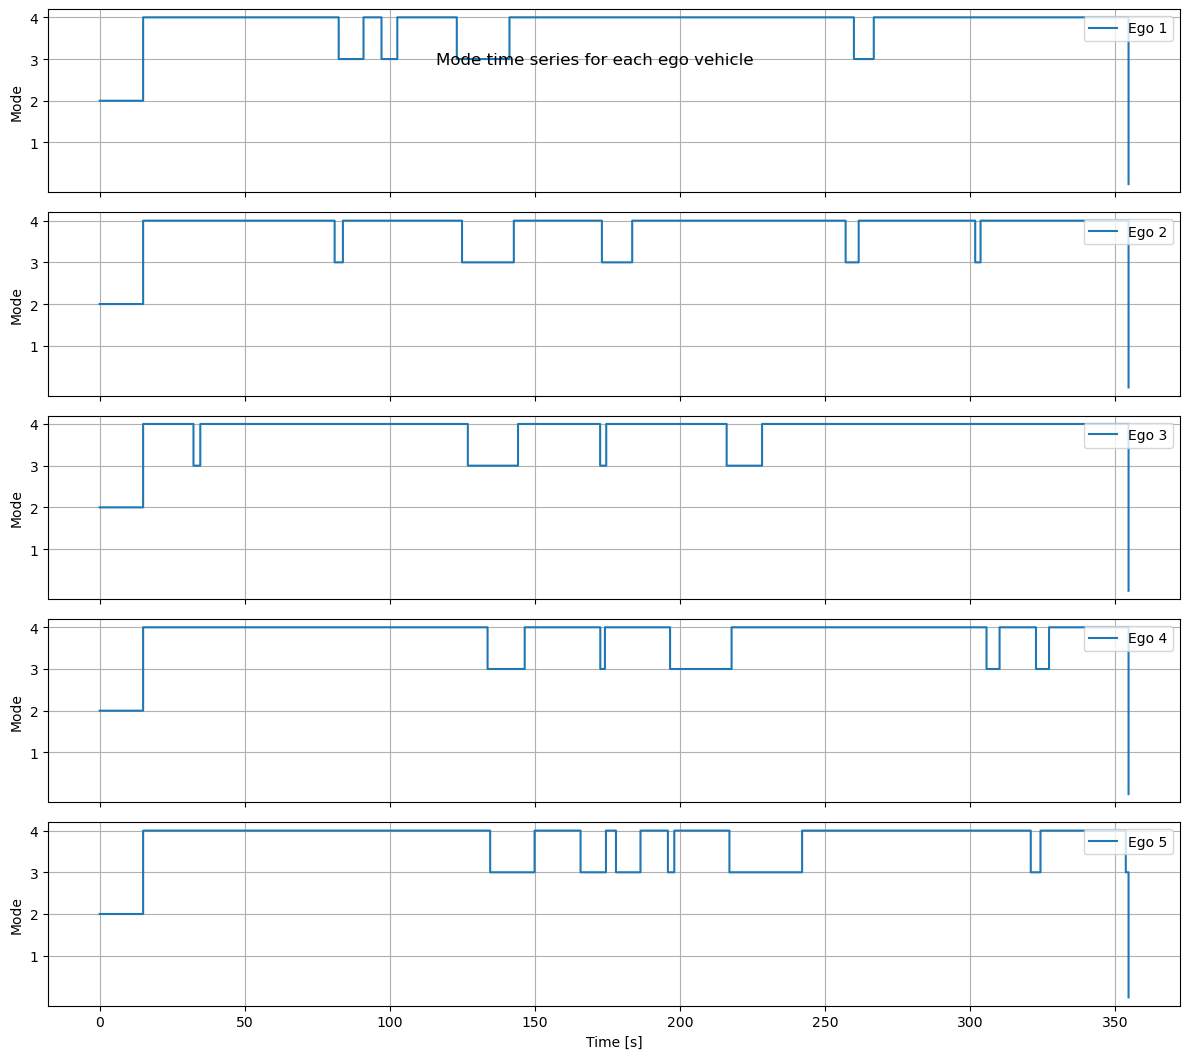

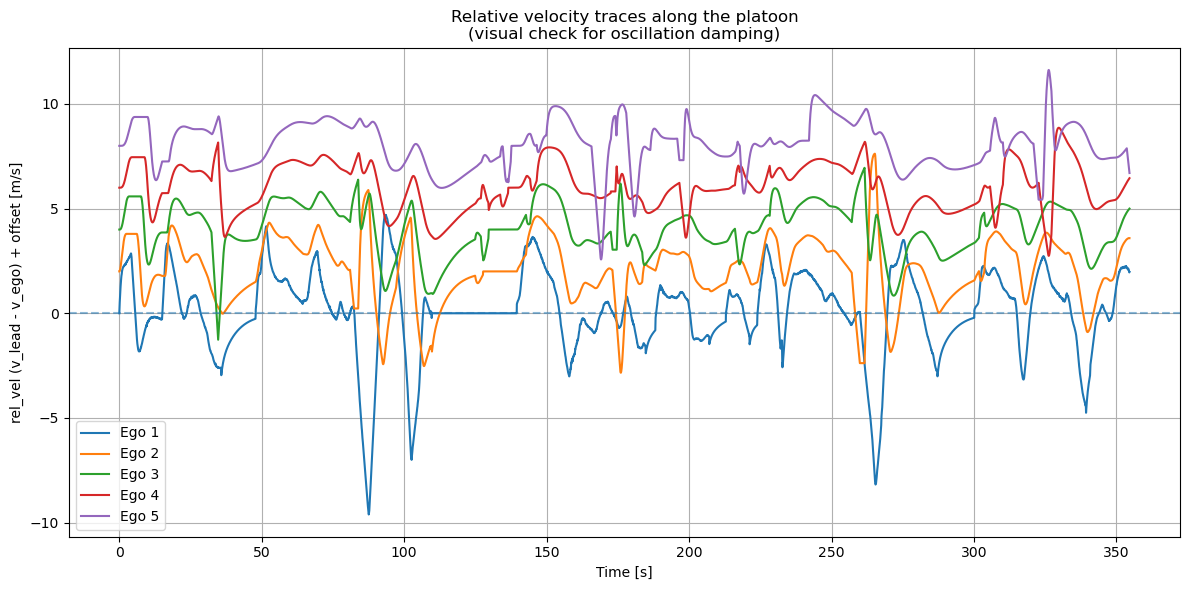

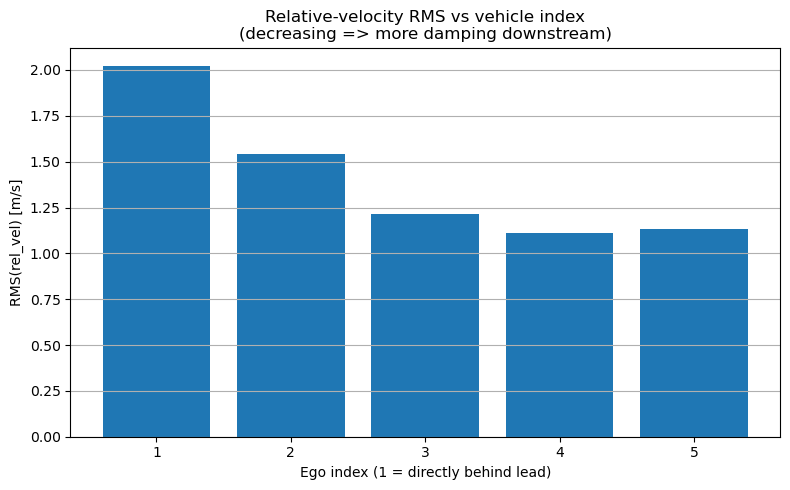

In [3]:
import rosbag
import numpy as np
import matplotlib.pyplot as plt

# Paths and global settings

bag_path = "/Users/katiegildersleeve/cs3892/src/rossim/taketwo_2025-11-13-14-05-51.bag"
Ts = 0.05  # controller sampling [s]

# ModeSelector tunables (same as MATLAB) 
S_NOLEADER   = 400.0   # [m]
COLLECT_SECS = 15.0    # [s]
S_JUMP_THR   = 15.0    # [m]
EWMA_TAU     = 3.0     # [s]
SIGMA_LOW    = 0.50    # [m/s]
SIGMA_HIGH   = 0.80    # [m/s]

# Controller tunables (same as MATLAB) 
S_MIN = 5.0
S_FAR = 400.0
V_DES = 25.0
A_MIN = -3.0
A_MAX = 1.5

# beta is the same proportional speed error gain used in Simulink model
BETA_CONST = 0.8  

# Alpha / Tau LUTs 
# mode: 1,2,3,4 -> index: 0,1,2,3
ALPHA_TABLE = np.array([0.75, 0.75, 1.0, 0.25])
TAU_TABLE   = np.array([0.75, 0.75, 0.5, 3.0])

def lookup_alpha_tau(mode_uint8):
    """Map mode ∈ {1,2,3,4} -> (alpha, tau) via 1-D LUTs."""
    idx = np.clip(int(mode_uint8) - 1, 0, 3)
    return ALPHA_TABLE[idx], TAU_TABLE[idx]


# ModeSelector (line-for-line Python port)

class ModeSelector:
    def __init__(self):
        self.inited = False

    def step(self, s, vL):
        if not self.inited:
            self.inited = True
            self.prev_s = s
            self.prev_present = (s <= S_NOLEADER)
            self.collect_cnt = int(self.prev_present * round(COLLECT_SECS / Ts))
            self.mu = vL
            self.var = 0.0
            self.last_mode = 1  # uint8 in MATLAB

        leader_present = (s <= S_NOLEADER)

        # start warm-up when leader first appears (no->yes)
        if leader_present and not self.prev_present:
            self.collect_cnt = int(round(COLLECT_SECS / Ts))
            self.mu = vL
            self.var = 0.0

        # restart warm-up on any large one-sample space-gap jump
        ds = s - self.prev_s
        if abs(ds) >= S_JUMP_THR:
            self.collect_cnt = int(round(COLLECT_SECS / Ts))
            self.mu = vL
            self.var = 0.0

        # EWMA update only when leader present
        alpha_ewma = Ts / max(EWMA_TAU, Ts)
        alpha_ewma = min(alpha_ewma, 1.0)

        if leader_present:
            self.mu = (1 - alpha_ewma) * self.mu + alpha_ewma * vL
            d = vL - self.mu
            self.var = (1 - alpha_ewma) * (self.var + alpha_ewma * d * d)
        else:
            self.mu = vL
            self.var = 0.0

        sigma = np.sqrt(max(self.var, 0.0))

        # Mode decision 
        if not leader_present:
            mode = 1
        else:
            if self.collect_cnt > 0:
                self.collect_cnt -= 1
                mode = 2
            else:
                if self.last_mode == 4:
                    mode = 3 if sigma <= SIGMA_LOW else 4
                else:
                    mode = 4 if sigma >= SIGMA_HIGH else 3

        # Bookkeeping
        self.last_mode = mode
        self.prev_s = s
        self.prev_present = leader_present
        return mode


# Controller (Python port of fcn.m)

def controller(sn, vn, dv, alpha, beta, tau):
    sn = float(sn)
    vn = float(vn)
    dv = float(dv)
    alpha = float(alpha)
    beta = float(beta)
    tau = float(tau)

    if sn > S_FAR:
        # Far from leader: simple speed hold
        a = beta * (V_DES - vn)
    else:
        sn_eff = max(sn - S_MIN, 0.0)
        a = alpha * (sn_eff - tau * vn) + beta * dv

        # Emergency rule: inside buffer and still closing -> full brake
        if sn <= S_MIN and dv < 0:
            a = A_MIN

    # Clamp
    a = max(min(a, A_MAX), A_MIN)
    return a


# Read lead vehicle from bag

lead_t = []
lead_v = []

with rosbag.Bag(bag_path) as bag:
    for topic, msg, ts in bag.read_messages():
        if topic == "/leadcar/car/state/vel_x":
            lead_t.append(ts.to_sec())
            lead_v.append(msg.data)

lead_t = np.array(lead_t)
lead_v = np.array(lead_v)

# Sort & resample to uniform grid at Ts
order = np.argsort(lead_t)
lead_t = lead_t[order]
lead_v = lead_v[order]

t0 = lead_t[0]
t_end = lead_t[-1]
t = np.arange(t0, t_end, Ts)

v_lead = np.interp(t, lead_t, lead_v)

# Integrate to get lead position
x_lead = np.zeros_like(t)
x_lead[1:] = np.cumsum(v_lead[:-1] * Ts)


# Platoon simulation (5 ego cars)

N_EGOS = 5
N = N_EGOS + 1       # 0 = lead, 1..5 = egos
n_steps = len(t)

x = np.zeros((N, n_steps))
v = np.zeros((N, n_steps))
mode = np.zeros((N, n_steps), dtype=int)
gap = np.zeros((N, n_steps))
rel_vel = np.zeros((N, n_steps))
accel = np.zeros((N, n_steps))

# Lead trajectory from bag
x[0, :] = x_lead
v[0, :] = v_lead
mode[0, :] = 0

# Improved initialization: each ego starts near steady-state time-gap
# Use "smooth" tau for initial desired gap
tau_smooth = TAU_TABLE[2]  # mode 3

mode_selectors = [None] + [ModeSelector() for _ in range(N_EGOS)]

for i in range(1, N):
    leader_i = i - 1
    v[i, 0] = v[leader_i, 0]               # same speed as leader
    s_des = S_MIN + tau_smooth * v[i, 0]   # nominal steady-state spacing
    x[i, 0] = x[leader_i, 0] - s_des       # place at desired gap

# Time stepping 
for k in range(n_steps - 1):
    for i in range(1, N):
        leader_i = i - 1
        s_n = x[leader_i, k] - x[i, k]
        vL = v[leader_i, k]
        vE = v[i, k]
        dv_rel = vL - vE

        # Mode selection
        mode_i = mode_selectors[i].step(s_n, vL)
        mode[i, k] = mode_i

        # Lookup gains
        alpha_i, tau_i = lookup_alpha_tau(mode_i)

        # Controller
        a_i = controller(s_n, vE, dv_rel, alpha_i, BETA_CONST, tau_i)
        accel[i, k] = a_i

        # Integrate ego dynamics
        v[i, k + 1] = max(vE + a_i * Ts, 0.0)
        x[i, k + 1] = x[i, k] + vE * Ts

        gap[i, k] = s_n
        rel_vel[i, k] = dv_rel

# fill last gaps / rel_vel
for i in range(1, N):
    gap[i, -1] = x[i - 1, -1] - x[i, -1]
    rel_vel[i, -1] = v[i - 1, -1] - v[i, -1]


# Visualizations

time_rel = t - t0

# Gaps vs time 
plt.figure(figsize=(12, 6))
for i in range(1, N):
    plt.plot(time_rel, gap[i], label=f"Ego {i} gap to car {i-1}")
plt.axhline(0.0, linestyle="--", label="0 m")
plt.axhline(S_MIN, linestyle=":", label="s_min")
plt.xlabel("Time [s]")
plt.ylabel("Gap s_n [m]")
plt.title("Inter-vehicle gaps for platoon (lead = car 0)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# One mode graph per ego (stacked)
fig, axes = plt.subplots(N_EGOS, 1, figsize=(12, 2.2 * N_EGOS), sharex=True)
for i in range(1, N):
    ax = axes[i - 1]
    ax.step(time_rel, mode[i], where="post", label=f"Ego {i}")
    ax.set_yticks([1, 2, 3, 4])
    ax.set_yticklabels(["1", "2", "3", "4"])
    ax.set_ylabel("Mode")
    ax.grid(True)
    ax.legend(loc="upper right")
axes[-1].set_xlabel("Time [s]")
fig.suptitle("Mode time series for each ego vehicle", y=0.92)
plt.tight_layout()

# Relative-velocity traces (visual damping) 
plt.figure(figsize=(12, 6))
offset = 2.0
for i in range(1, N):
    plt.plot(time_rel, rel_vel[i] + (i - 1) * offset, label=f"Ego {i}")
plt.axhline(0.0, linestyle="--", alpha=0.5)
plt.xlabel("Time [s]")
plt.ylabel("rel_vel (v_lead - v_ego) + offset [m/s]")
plt.title("Relative velocity traces along the platoon\n(visual check for oscillation damping)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# RMS amplitude of relative velocity per ego 
rms_rel = np.array([np.sqrt(np.mean(rel_vel[i] ** 2)) for i in range(1, N)])

plt.figure(figsize=(8, 5))
plt.bar(np.arange(1, N), rms_rel)
plt.xlabel("Ego index (1 = directly behind lead)")
plt.ylabel("RMS(rel_vel) [m/s]")
plt.title("Relative-velocity RMS vs vehicle index\n(decreasing => more damping downstream)")
plt.grid(True, axis="y")
plt.tight_layout()

plt.show()
